# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**


**NOTE to run code locally:** add data (data_d3.pickle, data_d4.pickle) to **assignment-3/data/** folder

## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [17]:
### Your code Here
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time


data_d3=pickle.load(open("data_d3.pickle", "rb"))

uniprot_ids = list(data_d3.keys())
structural_features = list(data_d3.values())

# Find the number of unique features
num_features = max(max(indices) for indices in structural_features) + 1

# Prepare data for csr_matrix
data = []
rows = []
cols = []

for row, indices in enumerate(structural_features):
    rows.extend([row] * len(indices))
    cols.extend(indices)
    data.extend([1] * len(indices))

# Create the sparse matrix
sparse_matrix = csr_matrix((data, (rows, cols)), shape=(len(uniprot_ids), num_features))

## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [18]:
### Add supporting functions here
import pickle
import numpy as np
from scipy.sparse import csr_matrix

def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == M:
                    SIGS[list(L), r] = i
                    L = {}
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T.todense()  # Convert the transposed sparse matrix to dense
    DataT = [set(np.where(DT[i] == 1)[1]) for i in range(M)]  # Use .todense() and adjust indexing
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

# Use LSHT to find similar proteins
B = 20
R =  10
buckets = LSHT(sparse_matrix, B, R)


# Function to time LSHT for given B and R
def time_LSHT(B, R):
    start_time = time.time()
    buckets = LSHT(sparse_matrix, B, R)
    end_time = time.time()
    return end_time - start_time

# Test different values of B and R
B_values = [5, 10, 15, 20, 32, 64]  # Adjust the values as needed
R_values = [5, 10, 15, 20, 32, 64]  # Adjust the values as needed

# Collect timing results
timing_results = {}
for B_val in B_values:
    for R_val in R_values:
        timing_results[(B_val, R_val)] = time_LSHT(B_val, R_val)
        

        
def DrawSimPlot(B, R):
    S=np.arange(0,1.0,.01)
    v=(1/B)**(1/R)
    P=1-(1-S**R)**B
    plt.figure(figsize=(7,5))
    plt.plot(S,P)
    plt.axvline(x = v, linestyle ="--", color ='r')
    plt.title("Candidate pairs probability for B=%d and R=%d" % (B,R))
    plt.xlabel("Document Similarity")
    plt.ylabel("Probability of being a candidate pair")

    plt.grid()
    plt.show()

B = 20
R =  10
        


Band 0 suggests these similar proteins: ['A0A024RBG1', 'Q9NZJ9']
Band 0 suggests these similar proteins: ['A0A075B6P5', 'P01615']
Band 0 suggests these similar proteins: ['A0A075B6S6', 'P06310']
Band 0 suggests these similar proteins: ['Q6IPX1', 'A0A087WVF3']
Band 0 suggests these similar proteins: ['A0A087WW87', 'P01614']
Band 0 suggests these similar proteins: ['A6NER0', 'A0A087X179']
Band 0 suggests these similar proteins: ['P07919', 'A0A096LP55']
Band 0 suggests these similar proteins: ['A0JP26', 'A0A0A6YYL3']
Band 0 suggests these similar proteins: ['A0A0B4J2D9', 'P0DP09']
Band 0 suggests these similar proteins: ['A0A0B4J2F2', 'P57059']
Band 0 suggests these similar proteins: ['P01742', 'A0A0B4J2H0']
Band 0 suggests these similar proteins: ['P01825', 'P0DP06', 'A0A0C4DH41']
Band 0 suggests these similar proteins: ['P01767', 'A0A0C4DH42']
Band 0 suggests these similar proteins: ['P01597', 'A0A0C4DH67', 'P04432']
Band 0 suggests these similar proteins: ['P01611', 'A0A0C4DH73']
Band 

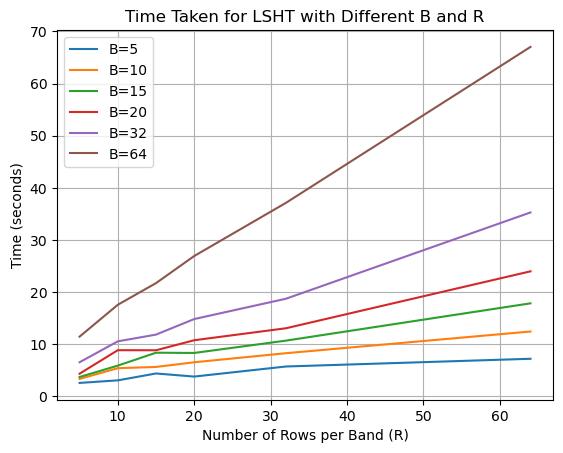

The probability that proteins share at least one band signature if they are 0.60 similar is:  0.1142
The probability that proteins share at least one band signature if they are 0.80 similar is:  0.8969


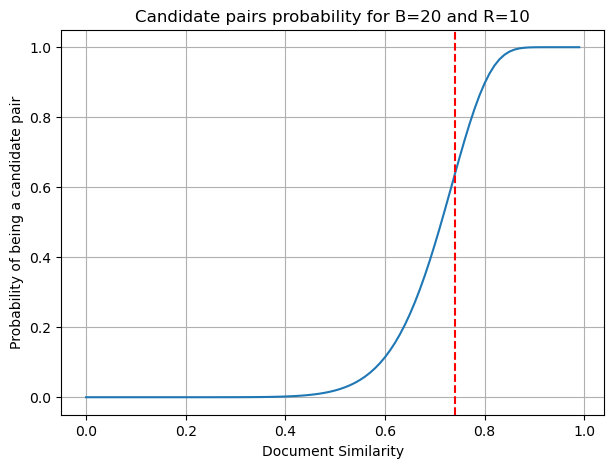

In [19]:

def print_similar_protein_pairs(buckets, uniprot_ids):
    # Print similar protein pairs
    for (b, buck), docs in buckets.items():
        if len(docs) > 1:
            similar_proteins = [uniprot_ids[d] for d in docs]
            print(f"Band {b} suggests these similar proteins: {similar_proteins}")

def plot_timing_results(B_values, R_values, timing_results):
    # Plotting
    fig, ax = plt.subplots()
    for B_val in B_values:
        timing_for_B = [timing_results[(B_val, R_val)] for R_val in R_values]
        ax.plot(R_values, timing_for_B, label=f"B={B_val}")

    ax.set_xlabel("Number of Rows per Band (R)")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Time Taken for LSHT with Different B and R")
    ax.legend()
    plt.grid(True)
    plt.show()

def print_probabilities(B, R):
    # Print probabilities
    s_values = [0.6, 0.8]
    for s in s_values:
        probability = 1 - (1 - s ** R) ** B
        print("The probability that proteins share at least one band signature if they are %4.2f similar is: %7.4f" % (s, probability))

def draw_similarity_plot(B, R):
    # Draw similarity plot
    DrawSimPlot(B, R)

# Call the functions
print_similar_protein_pairs(buckets, uniprot_ids)
plot_timing_results(B_values, R_values, timing_results)
print_probabilities(20, 10)
draw_similarity_plot(20, 10)

### Your short analysis here

Plan:
- use sparse matrices!
- use MinHashing to calculate the Jaccard Similarity as it is a good approach for large datasets (like d4)
- use LSHT instead of LSH as it heavily outperformes LSH for sparse matrices (which is the case for this data)


## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [24]:
### Add supporting functions here
dense_matrix = sparse_matrix.toarray()
dense_matrix
u,s,v =np.linalg.svd(dense_matrix)



U:
[[-1.52765832e-03 -3.96264898e-03  5.64027149e-03 ... -4.48218707e-03
   4.89792833e-04  3.23505684e-03]
 [-4.64479365e-03 -7.76916018e-03  3.33629600e-03 ... -7.35291914e-03
  -7.75057996e-03 -4.56062934e-03]
 [-3.49823757e-03 -9.19727302e-03 -2.75234139e-03 ... -2.14343711e-03
   7.70618533e-06 -3.01113528e-03]
 ...
 [-3.32357294e-03 -5.95630447e-03 -4.79320998e-05 ...  9.54658561e-01
   1.45450421e-03  1.48455221e-03]
 [-2.93466004e-03 -5.41263475e-03  1.73524503e-03 ...  1.32104043e-03
   9.62217724e-01 -1.25919389e-03]
 [-7.18530495e-03 -9.01769213e-03  5.15940019e-03 ...  8.88282360e-04
  -1.87625765e-03  9.42925294e-01]]
S:
[1.75451549e+03 2.76035214e+02 2.50583817e+02 ... 1.19005318e+00
 1.10372049e+00 9.28455780e-01]
V:
[[-4.96834464e-04 -7.18360750e-02 -6.79074835e-05 ... -4.12409668e-03
  -4.98740616e-04 -3.49529553e-03]
 [ 1.18756722e-03 -1.01979343e-01  5.95597301e-04 ...  1.35508192e-02
   6.79677946e-04  5.18977985e-03]
 [-1.68467540e-03  2.63717078e-03  2.02351312e-0

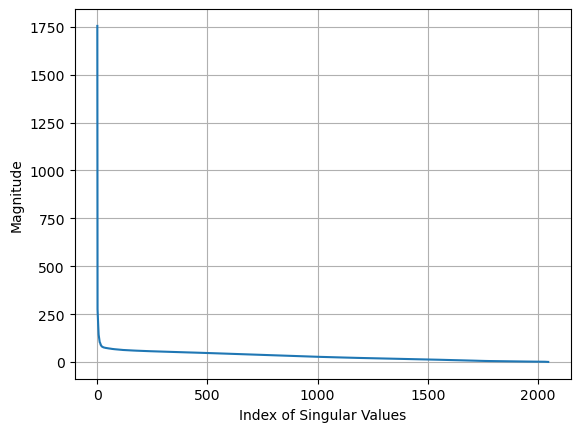

Number of components explaining at least 90% of variance: 683


In [25]:
### Add processing code here


print("U:")
print(u)
print("S:")
print(s)
print("V:")
print(v)



print("U shape:", u.shape)
print("S shape:", s.shape)
print("V shape:", v.shape)


plt.plot(s)
plt.xlabel('Index of Singular Values')
plt.ylabel('Magnitude')
plt.grid()
plt.show()



# Calculate the explained variance ratio
explained_variance_ratio = (s ** 2) / np.sum(s ** 2)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components that explain at least 90% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.90) + 1

print("Number of components explaining at least 90% of variance:", n_components)

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
